<a href="https://colab.research.google.com/github/LSzubelak/ls-projects/blob/main/Impact_500_program/500%2B_program_fertility_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eurostat
!pip install pycountry
!pip install SyntheticControlMethods

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 57.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for SyntheticControlMethods: filename=SyntheticControlMethods-1.1.17-py2.py3-none-any.whl size=27887 sha256=a4c80d266d1e5d77b571b51b2798c55acb8a74328d216330d03d91d2d2e9b8e1
  Stored in directory: /root/.cache/pip/wheels/8c/5b/e4/74efc1a7a25bab8db02401ccce0091da67574846bc849cb7b3
Successfully built SyntheticControlMethods


In [2]:
import eurostat
import pycountry
import pandas as pd
import matplotlib.pyplot as plt

# Fertility data

## **Data cleaning**

In [ ]:
import re
import eurostat
import pandas as pd
import pycountry

# 1. Download the raw fertility table and reset its index
df_wide = eurostat.get_data_df("tps00199")
df = df_wide.reset_index()

# 2. Identify & rename the geo‑code column
geo_col = [c for c in df.columns if 'geo' in c.lower()][0]
df = df.rename(columns={geo_col: "geo"})

# 3. Drop unneeded dims
df = df.drop(columns=["freq", "indic_de"], errors="ignore")

# 4. Detect true year columns (exactly four digits)
year_cols = [c for c in df.columns if re.fullmatch(r"\d{4}", str(c))]

# 5. Melt into long form
df_long = df.melt(
    id_vars=["geo"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Fertility Rate"
)

# 6. Build a fallback for codes pycountry won’t find
_manual = {
    "EL": "Greece",
    "UK": "United Kingdom",
    "XK": "Kosovo",
    # add more here if you spot unmapped codes…
}

def code_to_name(code):
    if code in _manual:
        return _manual[code]
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return code  # leave as‑is if still not found

# 7. Map every code → country name
df_long["Country"] = df_long["geo"].apply(code_to_name)

# 8. Clean up types & drop missing
df_long["Year"] = df_long["Year"].astype(int)
df_clean = (
    df_long
    .dropna(subset=["Fertility Rate"])
    [["Country", "Year", "Fertility Rate"]]
    .sort_values(["Country","Year"])
    .reset_index(drop=True)
)

print(df_clean.head(10))


   Country  Year  Fertility Rate
0  Albania  2012            1.71
1  Albania  2013            1.73
2  Albania  2014            1.73
3  Albania  2015            1.59
4  Albania  2016            1.54
5  Albania  2017            1.48
6  Albania  2018            1.37
7  Albania  2020            1.34
8  Albania  2021            1.31
9  Albania  2022            1.21


# Poland fertility chart

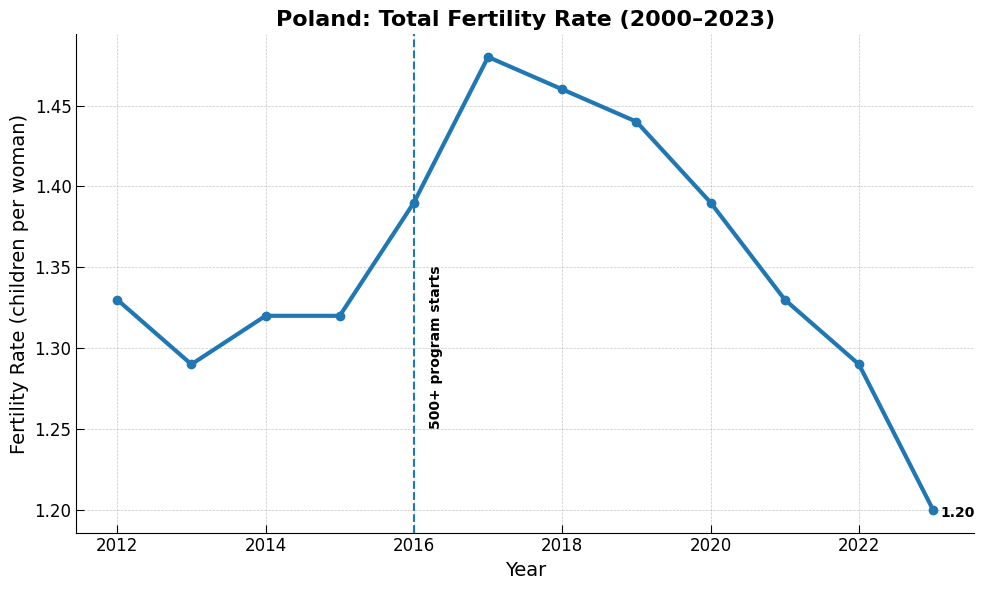

In [ ]:
import matplotlib.pyplot as plt

# Subset to Poland
df_pl = df_clean[df_clean['Country'] == 'Poland']

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line with thicker stroke and clear markers
ax.plot(
    df_pl['Year'],
    df_pl['Fertility Rate'],
    marker='o',
    linewidth=3,
    markersize=6
)

# Highlight the start of the 500+ program
ax.axvline(2016, linestyle='--', linewidth=1.5)
ax.text(
    2016 + 0.2,
    df_pl['Fertility Rate'].min() + 0.05,
    '500+ program starts',
    rotation=90,
    va='bottom',
    fontweight='bold'
)

# Label the final point value
last_year = df_pl['Year'].max()
last_value = df_pl.loc[df_pl['Year'] == last_year, 'Fertility Rate'].values[0]
ax.annotate(
    f'{last_value:.2f}',
    xy=(last_year, last_value),
    xytext=(5, -5),
    textcoords='offset points',
    fontweight='bold'
)

# Styling
ax.set_title('Poland: Total Fertility Rate (2000–2023)', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Fertility Rate (children per woman)', fontsize=14)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='in', length=6, labelsize=12)

plt.tight_layout()
# To save for blog or social media, uncomment:
# plt.savefig('poland_fertility_professional.png', dpi=300)

plt.show()


# EU fertility chart

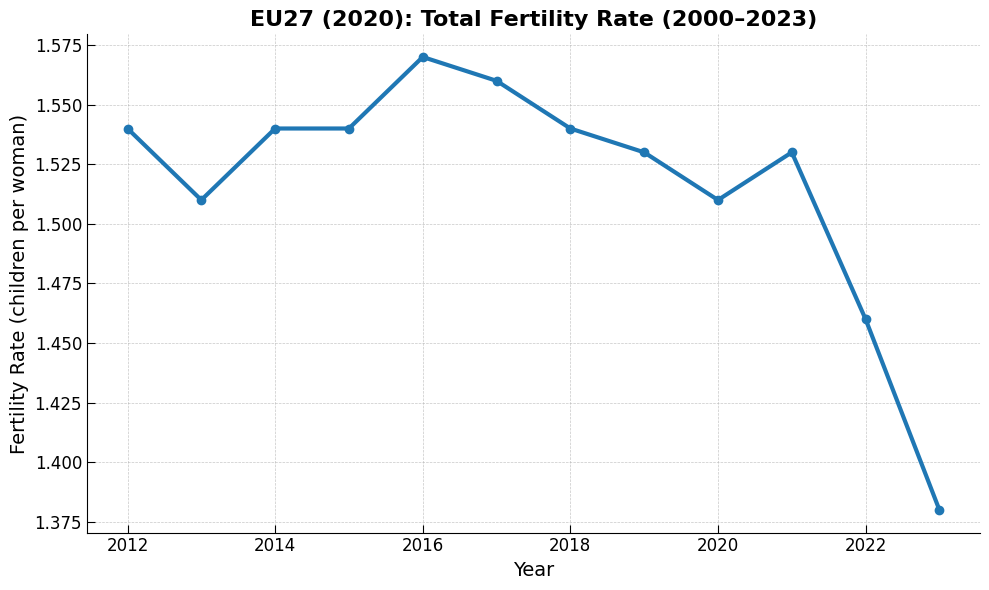

In [ ]:


# 1. Subset to the EU27_2020 aggregate
df_eu27 = df_clean[df_clean['Country'] == 'EU27_2020']

# 2. Build the figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    df_eu27['Year'],
    df_eu27['Fertility Rate'],
    marker='o',
    linewidth=3,
    markersize=6
)

# 3. Styling
ax.set_title('EU27 (2020): Total Fertility Rate (2000–2023)', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Fertility Rate (children per woman)', fontsize=14)

ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='in', length=6, labelsize=12)

plt.tight_layout()
# To export high‑res for social or blog:
# plt.savefig('eu27_2020_fertility_trend.png', dpi=300)

plt.show()


# Poland and neighborughs chart

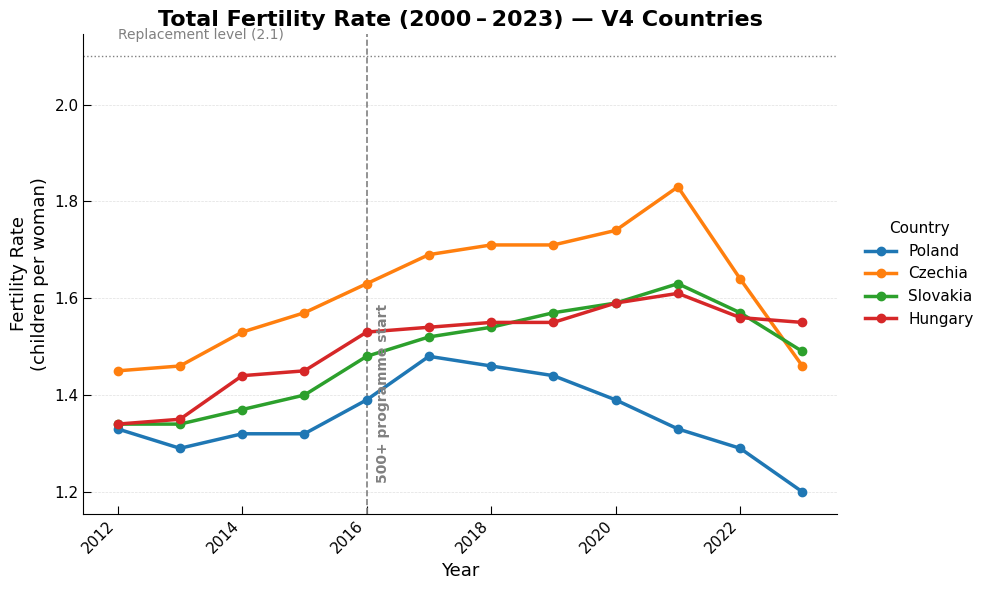

In [ ]:


# --- 1. V4 subset ----------------------------------------------------------
neighbors = ['Poland', 'Czechia', 'Slovakia', 'Hungary']
df_did    = df_clean[df_clean['Country'].isin(neighbors)].copy()

# --- 2. Figure & palette ---------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
palette = {
    'Poland':   '#1f77b4',   # blue   → highlight (like Poland bar)
    'Czechia':  '#ff7f0e',   # orange
    'Slovakia': '#2ca02c',   # green
    'Hungary':  '#d62728'    # red
}

# --- 3. Plot each country ---------------------------------------------------
for country in neighbors:
    d = df_did[df_did['Country'] == country]
    ax.plot(
        d['Year'], d['Fertility Rate'],
        marker='o',
        markersize=6,
        linewidth=2.5,
        color=palette[country],
        label=country,
        zorder=3
    )

# --- 4. Policy & reference lines -------------------------------------------
# 500+ vertical marker
ax.axvline(2016, color='gray', linestyle='--', linewidth=1.2)
ax.text(2016 + .15, ax.get_ylim()[0] + .05,
        '500+ programme start', rotation=90,
        va='bottom', color='gray', fontweight='bold')

# Replacement fertility (2.1) horizontal line
ax.axhline(2.1, color='gray', linestyle=':', linewidth=1)
ax.text(df_did['Year'].min(), 2.13,
        'Replacement level (2.1)',
        color='gray', fontsize=10, va='bottom')

# --- 5. Styling to mirror RMSPE chart --------------------------------------
ax.set_title('Total Fertility Rate (2000 – 2023) — V4 Countries',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Year',  fontsize=13)
ax.set_ylabel('Fertility Rate\n(children per woman)', fontsize=13)

# Light gray dashed grid (y only)
ax.grid(axis='y', linestyle='--', linewidth=0.5, color='lightgray', alpha=0.7)
ax.set_axisbelow(True)                        # grid behind lines

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tick styling
ax.tick_params(direction='in', length=6, labelsize=11)
plt.xticks(rotation=45, ha='right')

# Legend — simple & outside left
ax.legend(title='Country', fontsize=11, title_fontsize=11,
          frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5))

# --- 6. Layout & export -----------------------------------------------------
plt.tight_layout()
plt.savefig('v4_fertility_did_chart_styled.png', dpi=300)
plt.show()


# Difference-in-difference

In [ ]:


# 1. Subset to Poland and its neighbors
neighbors = ['Poland', 'Czechia', 'Slovakia', 'Hungary']
df_did = df_clean[df_clean['Country'].isin(neighbors)].copy()

# 2. Create DiD covariates
df_did['treated'] = (df_did['Country'] == 'Poland').astype(int)
df_did['post']    = (df_did['Year'] >= 2016).astype(int)
df_did['did']     = df_did['treated'] * df_did['post']

# 3. Run OLS with country & year FE, clustering SEs by country
#    We use Q("Fertility Rate") to handle the space in the variable name.
formula = 'Q("Fertility Rate") ~ treated + post + did + C(Country) + C(Year)'
model   = smf.ols(formula, data=df_did).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_did['Country']}
)

# 4. Inspect results
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     Q("Fertility Rate")   R-squared:                       0.899
Model:                             OLS   Adj. R-squared:                  0.852
Method:                  Least Squares   F-statistic:                     2.708
Date:                 Tue, 15 Jul 2025   Prob (F-statistic):              0.218
Time:                         18:29:54   Log-Likelihood:                 83.261
No. Observations:                   48   AIC:                            -134.5
Df Residuals:                       32   BIC:                            -104.6
Df Model:                           15                                         
Covariance Type:               cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 3
  warnings.warn('covariance of constraints does not have full '


In [ ]:

# 5. Pre‑COVID DiD (2000–2019)
df_pre_covid = df_did[df_did['Year'] < 2020].copy()
model_pre_covid = smf.ols(formula, data=df_pre_covid).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_pre_covid['Country']}
)
print("\n=== Pre‑COVID DiD (2000–2019) ===")
print(model_pre_covid.summary())


=== Pre‑COVID DiD (2000–2019) ===
                             OLS Regression Results                            
Dep. Variable:     Q("Fertility Rate")   R-squared:                       0.972
Model:                             OLS   Adj. R-squared:                  0.957
Method:                  Least Squares   F-statistic:                     9.889
Date:                 Tue, 15 Jul 2025   Prob (F-statistic):             0.0459
Time:                         18:30:48   Log-Likelihood:                 81.004
No. Observations:                   32   AIC:                            -138.0
Df Residuals:                       20   BIC:                            -120.4
Df Model:                           11                                         
Covariance Type:               cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 3
  warnings.warn('covariance of constraints does not have full '


# Synthetic control group class

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toolz import partial
from scipy.optimize import fmin_slsqp

# ---------------------------------------------------------------------
# 1.  Synthetic‑control estimator with weight regularisation
# ---------------------------------------------------------------------
class SyntheticControlWithWeights:
    """Classic SCM with L2‑penalty toward uniform weights and simplex constraints."""

    def loss(self, W, X, y, reg):
        mse      = np.mean((y - X @ W)**2)
        penalty  = reg * np.sum((W - 1 / X.shape[1])**2)
        return np.sqrt(mse + penalty)

    def fit(self, X, y, regularization_weight=0.0):
        w0 = np.ones(X.shape[1]) / X.shape[1]                    # uniform start
        self.coef_ = fmin_slsqp(
            func     = partial(self.loss, X=X, y=y, reg=regularization_weight),
            x0       = w0,
            f_eqcons = lambda w: np.sum(w) - 1,                  # Σw = 1
            bounds   = [(0, 1)] * len(w0),                       # 0 ≤ w ≤ 1
            disp     = False
        )
        self.mse_ = self.loss(self.coef_, X, y, regularization_weight)
        return self

    def predict(self, X):
        return X @ self.coef_



# Synthetic control group

In [ ]:

# --------------------------------------------------------------------
# 2.  Build a balanced donor panel (all countries except Poland & aggregates)
# --------------------------------------------------------------------
TREATED       = "Poland"
T0            = 2015                     # last pre‑treatment year
AGG_CODES     = {"EU27_2020", "EA19", "EA20", "FX"}   # aggregated entities

# Wide Year × Country matrix
wide = (
    df_clean
      .loc[~df_clean['Country'].isin(AGG_CODES)]   # drop aggregates
      .pivot(index='Year', columns='Country', values='Fertility Rate')
      .sort_index()
)

# Keep only rows & columns with complete data
wide_bal = wide.dropna(axis=1)         # drop donors with any NA
wide_bal = wide_bal.dropna()           # drop years still containing NA

donors = [c for c in wide_bal.columns if c != TREATED]

print(f"Balanced panel: {wide_bal.shape[0]} years × "
      f"{wide_bal.shape[1]} units ({len(donors)} donors + Poland)")

# Pre‑treatment matrices
X_pre = wide_bal.loc[:T0, donors].values
y_pre = wide_bal.loc[:T0, TREATED].values

# Full‑period matrices
X_full = wide_bal[donors]
y_full = wide_bal[TREATED]

Balanced panel: 12 years × 34 units (33 donors + Poland)


In [ ]:
# ---------------------------------------------------------------------
# 3.  Fit SCM weights with a small regularisation penalty
# ---------------------------------------------------------------------
scm = SyntheticControlWithWeights().fit(X_pre, y_pre, regularization_weight=0.001)

synthetic = X_full @ scm.coef_
gap       = y_full - synthetic
ate       = gap.loc[2016:].mean()

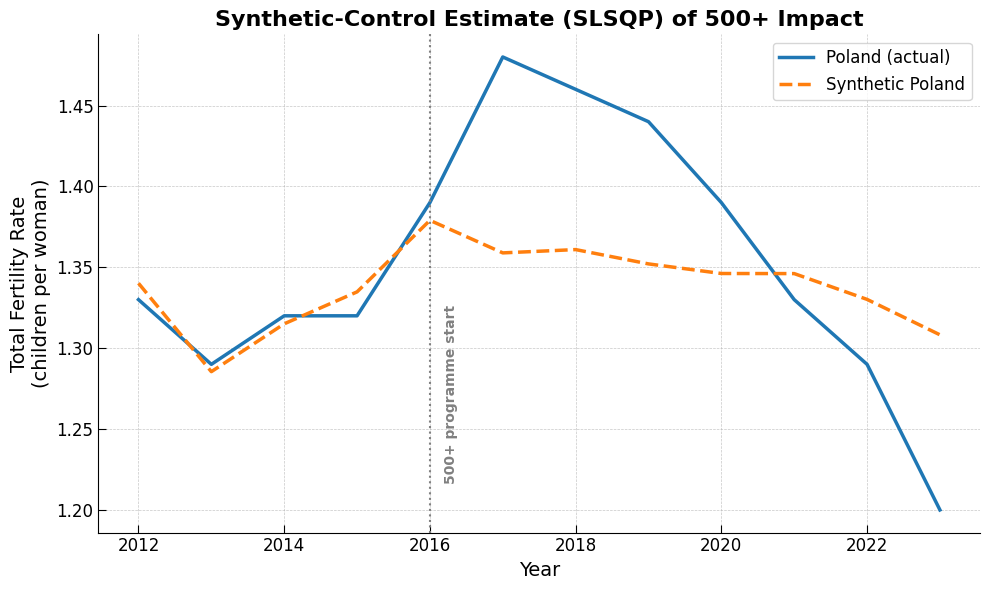

In [ ]:

# ---------------------------------------------------------------------
# 4.  Plot actual vs. synthetic Poland
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(panel.index, panel['Poland'],  label='Poland (actual)',  linewidth=2.5)
ax.plot(panel.index, synthetic,        label='Synthetic Poland', linestyle='--', linewidth=2.5)

ax.axvline(2016, color='gray', linestyle=':', linewidth=1.5)
ax.text(2016 + .2, ax.get_ylim()[0] + .03, '500+ programme start',
        rotation=90, va='bottom', color='gray', fontweight='bold')

ax.set_title('Synthetic‑Control Estimate (SLSQP) of 500+ Impact', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Fertility Rate\n(children per woman)', fontsize=14)
ax.grid(True, linestyle='--', linewidth=.5, alpha=.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=12)
ax.tick_params(direction='in', length=6, labelsize=12)
plt.tight_layout()
plt.show()


# Synthetic control group weights

In [ ]:

# ---------------------------------------------------------------------
# 5.  Display weights and ATE
# ---------------------------------------------------------------------
weights = pd.Series(scm.coef_, index=donors).sort_values(ascending=False)
print("\nDonor weights (SLSQP):")
print(weights)

print(f"\nAverage post‑2016 treatment effect (ATE): {ate:.3f} children per woman")


Donor weights (SLSQP):
Portugal           2.490392e-01
Spain              2.401981e-01
Greece             1.864128e-01
Cyprus             1.158363e-01
Italy              8.292447e-02
Slovakia           7.575983e-02
Liechtenstein      3.857408e-02
Malta              1.125520e-02
Croatia            6.456440e-17
Ireland            6.002211e-17
Estonia            5.593014e-17
Hungary            3.855243e-17
Austria            2.051637e-17
Slovenia           1.586189e-17
Netherlands        4.649480e-18
France             4.068173e-18
Sweden             3.794387e-18
Latvia             2.748026e-18
Norway             9.307446e-19
Denmark            0.000000e+00
Germany            0.000000e+00
Belgium            0.000000e+00
Czechia            0.000000e+00
Finland            0.000000e+00
Bulgaria           0.000000e+00
Iceland            0.000000e+00
Montenegro         0.000000e+00
Lithuania          0.000000e+00
Luxembourg         0.000000e+00
North Macedonia    0.000000e+00
Romania         

# Placebo test

               unit  rmspe_pre  rmspe_post       ratio
30         Slovenia   0.000350    0.058156  166.274579
28           Serbia   0.001093    0.111696  102.185107
21            Malta   0.002684    0.223006   83.077592
24  North Macedonia   0.001557    0.112386   72.166067
6           Czechia   0.002399    0.120664   50.301211


/tmp/ipython-input-72-1454635438.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(placebo_df["unit"], rotation=45, ha="right", fontsize=10)


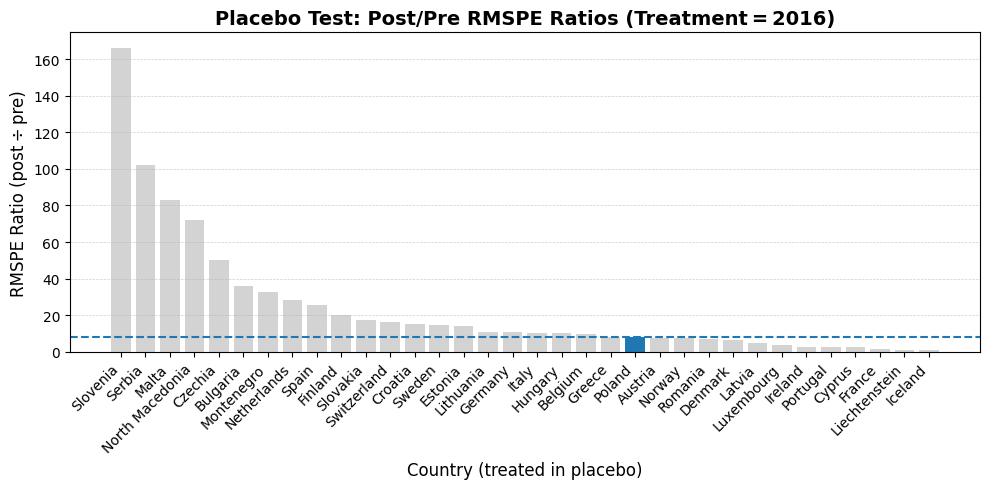


Poland's RMSPE ratio rank: 22 out of 34


In [ ]:
"""
PLACEBO (IN‐SPACE) TEST
-----------------------
Repeats the synthetic‐control construction for *every* country in the balanced
panel, pretending each one is “treated” in 2016.  Compares Poland’s post‑/pre‑
RMSPE ratio to the distribution of placebo ratios.

Assumes the *balanced* wide matrix `wide_bal`, donor list `donors`,
treated unit name `TREATED`, and class `SyntheticControlWithWeights`
have already been created (see previous snippet).
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Helper: fit SCM for a given unit and return pre/post RMSPE
# ------------------------------------------------------------------
def scm_rmspe_ratio(unit, reg=0.001):
    donor_pool = [c for c in wide_bal.columns if c != unit]

    # Pre‑treatment fit
    X_pre = wide_bal.loc[:T0, donor_pool].values
    y_pre = wide_bal.loc[:T0, unit].values

    model = SyntheticControlWithWeights().fit(X_pre, y_pre, regularization_weight=reg)

    # Synthetic series over full horizon
    synthetic = wide_bal[donor_pool] @ model.coef_
    gap = wide_bal[unit] - synthetic

    rmspe_pre  = np.sqrt(np.mean(gap.loc[:T0]**2))
    rmspe_post = np.sqrt(np.mean(gap.loc[2016:]**2))

    return rmspe_pre, rmspe_post, rmspe_post / rmspe_pre

# ------------------------------------------------------------------
# 2. Run placebo for every unit (treated + donors)
# ------------------------------------------------------------------
placebo_rows = []
for unit in [TREATED] + donors:
    pre, post, ratio = scm_rmspe_ratio(unit)
    placebo_rows.append({
        "unit":  unit,
        "rmspe_pre":  pre,
        "rmspe_post": post,
        "ratio":      ratio
    })

placebo_df = pd.DataFrame(placebo_rows).sort_values("ratio", ascending=False)
print(placebo_df.head())

# ------------------------------------------------------------------
# 3. Plot distribution of RMSPE ratios (Poland highlighted)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(
    x=placebo_df["unit"],
    height=placebo_df["ratio"],
    color=["#1f77b4" if u == TREATED else "lightgray" for u in placebo_df["unit"]]
)
ax.axhline(placebo_df.loc[placebo_df["unit"] == TREATED, "ratio"].values[0],
           color="#1f77b4", linestyle="--")

ax.set_title("Placebo Test: Post/Pre RMSPE Ratios (Treatment = 2016)",
             fontsize=14, fontweight="bold")
ax.set_ylabel("RMSPE Ratio (post ÷ pre)", fontsize=12)
ax.set_xlabel("Country (treated in placebo)", fontsize=12)
ax.set_xticklabels(placebo_df["unit"], rotation=45, ha="right", fontsize=10)
ax.grid(True, axis="y", linestyle="--", linewidth=.5, alpha=.6)
plt.tight_layout()
# plt.savefig("placebo_rmspe_ratios.png", dpi=300)
plt.show()

# ------------------------------------------------------------------
# 4. Where does Poland sit?
# ------------------------------------------------------------------
rank = placebo_df.reset_index(drop=True)
poland_rank = rank.index[rank["unit"] == TREATED][0] + 1
print(f"\nPoland's RMSPE ratio rank: {poland_rank} out of {len(rank)}")
